In [21]:
from astropy.table import Table
from astropy.io import ascii
import pandas
import astropy.units as u
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import scipy.stats as stats

In [ ]:
# Start by reading in data from BB20 model of protoplanetary composition. 

In [2]:
BBmodel = ascii.read("./BitschFig10/Combineddata.csv",data_start=2)
BBmodel.rename_column('\ufeffFe_H', 'Fe_H')
print(BBmodel)

Fe_H  Fe3O4_top    FeS_top   ... Fe2O3_bottom MgSiO3_bottom     H20    
---- ----------- ----------- ... ------------ ------------- -----------
-0.3 0.101077057 0.196159024 ...   0.05451802   0.152905112  0.48193737
-0.2 0.108711491 0.192318049 ...   0.06226184   0.152584418 0.438068289
-0.1 0.114706581 0.188492912 ...   0.06838804   0.147425014 0.405484814
 0.0  0.12071751 0.187930625 ...   0.07613186    0.16000283  0.35032541
 0.1 0.120155223 0.187368338 ...   0.08226278   0.161295039 0.287096774
 0.2 0.121248119 0.188429556 ...    0.0883937   0.162582532 0.214195435
 0.3  0.11575196  0.19280114 ...   0.09129881   0.178395586 0.152584418
 0.4 0.116844856 0.188976004 ...   0.10065082    0.16032824 0.066779853


In [3]:
Comp = Table(BBmodel)
Comp

Fe_H,Fe3O4_top,FeS_top,Mg2SiO4_top,Fe2_O3_top,MgSiO3_top,Fe3O4_bottom,FeS_bottom,Mg2SiO4_bottom,Fe2O3_bottom,MgSiO3_bottom,H20
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-0.3,0.101077057,0.196159024,0.324027877,0.104355746,0.301092896,0.054518015,0.099679306,0.164195435,0.05451802,0.152905112,0.48193737
-0.2,0.108711491,0.192318049,0.341498376,0.112006019,0.27756395,0.060644218,0.105810224,0.186455386,0.06226184,0.152584418,0.438068289
-0.1,0.114706581,0.188492912,0.358968876,0.119640453,0.255706027,0.06838804,0.108715337,0.205484814,0.06838804,0.147425014,0.405484814
0.0,0.12071751,0.187930625,0.35514374,0.122356854,0.25514374,0.076131862,0.118067346,0.222906055,0.07613186,0.16000283,0.35032541
0.1,0.120155223,0.187368338,0.379171616,0.123433911,0.236548666,0.080649877,0.127424071,0.259682135,0.08226278,0.161295039,0.287096774
0.2,0.121248119,0.188429556,0.401575988,0.124510969,0.219608775,0.088393699,0.138393699,0.302909828,0.0883937,0.162582532,0.214195435
0.3,0.11575196,0.19280114,0.410849766,0.119046488,0.222309337,0.088068289,0.150976231,0.331621392,0.09129881,0.178395586,0.152584418
0.4,0.116844856,0.188976004,0.451271086,0.120123545,0.184057971,0.097425014,0.16516695,0.403876627,0.10065082,0.16032824,0.066779853


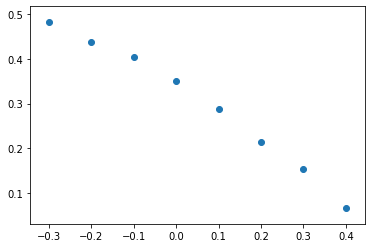

In [4]:
plt.scatter(BBmodel['Fe_H'],BBmodel['H20'])

In [5]:
# Now interpolate between points

model_poly = models.Polynomial1D(degree=3)
fitter_poly = fitting.LinearLSQFitter()
best_fit_poly = fitter_poly(model_poly, BBmodel['Fe_H'],BBmodel['H20'])

print(best_fit_poly)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
            c0                  c1                  c2                  c3        
    ------------------ ------------------- ------------------- -------------------
    0.3480026126904762 -0.5659026289285716 -0.3847110642857163 0.12633408333333815


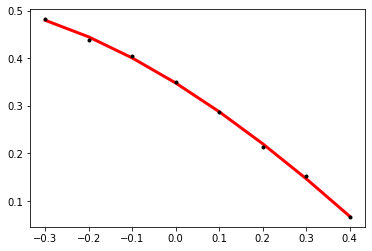

In [6]:
plt.errorbar(BBmodel['Fe_H'],BBmodel['H20'], fmt='k.')
plt.plot(BBmodel['Fe_H'],best_fit_poly(BBmodel['Fe_H']),color='r', linewidth=3)

In [10]:
# Now read in fiducal MW model. 
# 17th Friends-of-Friends group in the Reference model 25Mpc simulation, hence FOF17_Ref-L025N376.dat

Tedmodel = ascii.read("EAGLE_MW_L0025N0376_REFERENCE_ApogeeRun_30kpc_working.dat",data_start=2)

In [13]:
# Clean up model, assuming lowest metallicity star particles don't contribute. 

from astropy.table import Table, Column, MaskedColumn
Tedmodel = Table(Tedmodel, masked=True, copy=False)

cleanmodel=Tedmodel[Tedmodel['fe_h'] > -3.0]

<ErrorbarContainer object of 3 artists>

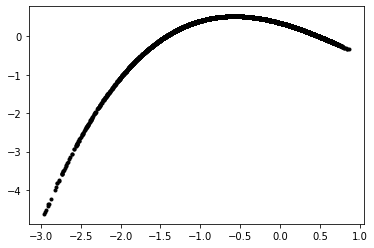

In [15]:
Water = best_fit_poly(cleanmodel['fe_h'])
cleanmodel['Water'] = Water
plt.errorbar(cleanmodel['fe_h'],cleanmodel['Water'], fmt='k.')

In [18]:
#Set minimum water content at 5%. This is completely arbritary, and corresponds to extrapolating beyond the limits of the BB20 model.

Minwater=cleanmodel['Water']

for nrow in range(0,len(cleanmodel)-1):
       Minwater[nrow]=np.where(cleanmodel['Water'][nrow]<0.05,0.05,cleanmodel['Water'][nrow])

# Minwater.info('stats')

cleanmodel['MinWater']=Minwater 

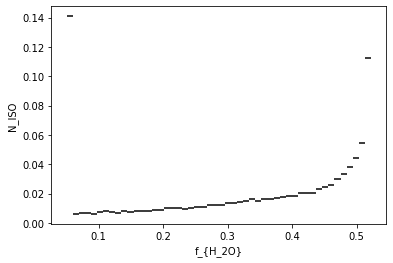

In [23]:
#Calculate mass fraction and plot

massdist, bin_edges, binnumber = stats.binned_statistic(cleanmodel['MinWater'],cleanmodel['mass'], 'sum', bins=50)

# print(massdist)

tmp = np.sum(massdist)

massdist = massdist/tmp

#print(massdist)

#print(np.sum(massdist))

#print(bin_edges)

plt.figure()
plt.xlabel('f_{H_2O}')
plt.ylabel('N_ISO')
plt.hlines(massdist,bin_edges[:-1],bin_edges[1:])

In [ ]:
#Now sp